In [2]:
import numpy as np
from numpy.random import multinomial

from scipy.special import logsumexp, digamma

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

# Same Difference: Estimation and Inference for Distinctiveness at Westminster
- Spirling, Huang, and Perry
- Discussion notebook by Jacob Eisenstein

# Quantifying distinctive speech

- Spirling et al propose a novel metric for quantifying the distinctiveness of a legislator's speech, in comparison with other legislators from the same session.
- Draws on ideas from author identification (e.g. Mosteller and Wallace 1964, Juola 2008, Stamatatos 2009)
- A speaker is distinctive to the extent that they are recognizable to a statistical classifier.


# The details

- For each word $v$, compute the empirical frequency rate for author $s$
    \begin{align}
    \hat{p}(v \mid s) = &{} \frac{n_{v,s} + \alpha}{\sum_{v'} (n_{v',s} + \alpha)}\\
    \eta_{v,s} \triangleq &{} \log \hat{p}(v \mid s)
    \end{align}
- $\eta$ parametrizes the log-odds of authors $s$ and $t$ conditioned on bag-of-words $\vec{x}$:
    \begin{align}
    d_{s,t} = &{} \log \frac{p(\vec{x} \mid s)}{p(\vec{x} \mid t)} = \frac{1}{N_s} \sum_{v} x_v (\eta_{s,v} - \eta_{t,v})
    \end{align}
    This is the KL-divergence $D_{\text{KL}}(\hat{p}_{s} || \hat{p}_t)$
- The distinctiveness of each author is computed with respect to the average $\overline{\eta}$,
    \begin{align}
    \overline{\eta}_{v} = &{} \frac{1}{|S|} \sum_{s=1}^S \eta_{s,v}\\
    \mathbb{D}_s = &{} \sum_v \hat{p}_{s,v} (\eta_{s,v} - \overline{\eta}_{t,v})
    \end{align}


# Questions for discussion

- Does this method work?
- Is there a Bayesian alternative?

# Testing on synthetic data

- Imagine we have three legislators, $a, b, c$
- The (unseen) true word distributions for $a$ and $b$ are the same
- The word distribution for $c$ is different

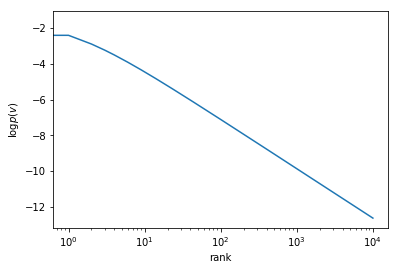

In [3]:
V = 10000 # vocabulary size
zipf_coef = 1.2 

# unnormalized probabilities
p_word = np.array([r**(-zipf_coef) for r in range(1,V)])

# normalized log-probabilities
log_p_word = np.log(p_word) - np.log(p_word.sum())

plt.semilogx(log_p_word)
plt.xlabel('rank')
plt.ylabel('$\\log p(v)$');

- Now let's generate an alternative word distribution for legislator $c$
- This legislator has a set of "favorite words", which are far more likely
- The probabilities of other words are decreased correspondingly

In [4]:
num_faves = 50
fave_bonus = 5 #increase in log-probability for favorite words 

faves = np.random.randint(20,V-1,num_faves)
log_p_word_c = log_p_word.copy()
log_p_word_c[faves] += np.log(fave_bonus)
log_p_word_c -= logsumexp(log_p_word_c)

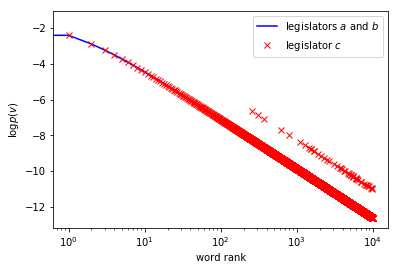

In [5]:
plt.semilogx(log_p_word,'b-')
plt.semilogx(log_p_word_c,'rx')
plt.xlabel('word rank')
plt.ylabel('$\\log p(v)$');
plt.legend(['legislators $a$ and $b$','legislator $c$']);

# A test

- Does the method successfully identify $c$ as more distinctive than $a$ and $b$?
- To answer, we need to generate actual text, and then apply the method

In [6]:
# N_speeches, words_per_speech from appendix C of SI
def generate_data(log_p_word,num_faves=50,fave_bonus=5,N_speeches=50,words_per_speech=200):
    faves = np.random.randint(20,V-1,num_faves)
    log_p_word_c = log_p_word.copy()
    log_p_word_c[faves] += np.log(fave_bonus)
    log_p_word_c -= logsumexp(log_p_word_c)
    
    log_p_words = np.vstack([log_p_word,log_p_word,log_p_word_c])
    x = [multinomial(words_per_speech,np.exp(log_p_words_s),N_speeches)
         for log_p_words_s in log_p_words]

    return x

In [14]:
x = generate_data(log_p_word)
# data is list of bag-of-words matrices
for x_i in x:
    print(x_i[:3])
    print()

[[38 26 12 ...  0  0  0]
 [44 22 14 ...  0  0  0]
 [38 14 14 ...  0  0  0]]

[[39 25  8 ...  0  0  0]
 [41 17 15 ...  0  0  0]
 [37 24 15 ...  0  0  0]]

[[39 18 13 ...  0  0  0]
 [52 18  7 ...  0  0  0]
 [38 20 12 ...  0  0  0]]



In [212]:
# smoothing value from PC with the authors
def compute_D(x, smoothing = 0.5, bayesian= False):
    if bayesian:
        eta = np.vstack([digamma(smoothing + x_i.sum(0)) - digamma(V*smoothing + x_i.sum()) for x_i in x])
    else:
        eta = np.vstack([np.log(smoothing + x_i.sum(0)) - np.log(V*smoothing + x_i.sum()) for x_i in x])
    f_bar = np.vstack([np.dot(np.diag(1./x_s.sum(1)),x_s).mean(0) for x_s in x])
    eta_bar = eta.mean(0)
    D = np.diag(np.dot(f_bar,(eta - eta_bar).T))
    return D

In [213]:
compute_D(x)

array([0.11714394, 0.11454579, 0.12189767])

- In this case, it works! Legislator $c$ is the most distinctive of the three. 
- How often does this happen in general?

In [216]:
num_correct = 0
N_trials = 300
for _ in range(N_trials):
    output = compute_D(generate_data(log_p_word))
    num_correct += (output.argmax() == 2)
print(f'accuracy: {num_correct/N_trials}')

accuracy: 0.6666666666666666


2/3 of the time, the method identifies $c$ as the most distinctive legislator.

- How does this depend on:
    - the true underlying differences between legislators?
    - the amount of data?
    - the amount of smoothing?
    - violations of the independence assumptions?

# A Bayesian perspective

\begin{align}
\vec{\theta}_s \sim &{} \text{Dirichlet}(\alpha \vec{1})\\
\vec{x} \mid \vec{\theta}_s \sim  &{} \text{Multinomial}(\vec{\theta}_s, N_s)\\
\vec{\theta}_s \mid \vec{x}, \alpha \sim &{} \text{Dirichlet}(\vec{x} + \alpha)
\end{align}

This generative model makes it possible to compute the expected log-probability, rather than taking the log of the point estimate:

\begin{align}
E[\log \theta_{s,v}] = &{} \psi(x_{s,v} + \alpha) - \psi(V \alpha + \sum_{v'} x_{s,v'}),
\end{align}
where $\psi$ is the digamma function. Might this Bayesian approach be more robust to small data?

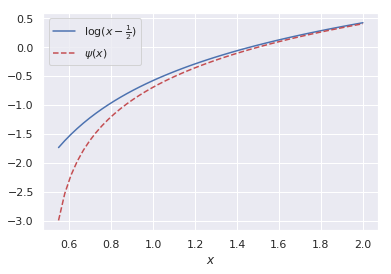

In [262]:
# the digamma function
x = np.linspace(0.55, 2)
plt.plot(x,digamma(x),'b-')
plt.plot(x,np.log(x-.5),'r--')
plt.xlabel('$x$')
plt.legend(['$\\log(x - \\frac{1}{2})$','$\\psi(x)$']);

In [227]:
num_correct = 0
N_trials = 300
for _ in range(N_trials):
    output = compute_D(generate_data(log_p_word),bayesian=True)
    num_correct += (output.argmax() == 2)
print(f'accuracy: {num_correct/N_trials}')

accuracy: 0.7633333333333333


Better! Does this hold systematically?

In [168]:
smoothers = [.01, .1, .5, 1.]
num_speeches = [25, 50, 100, 200]
N_samp = 1000

accuracies = dict()

linestyles = ['k-','b:','r--','g-.']

records = []
for smoother,linestyle in tqdm_notebook(zip(smoothers,linestyles)):
    accs = []
    for num_speech in tqdm_notebook(num_speeches):
        record_map = {'smoother':smoother,
                  'N_speech':num_speech,
                  'method':'MAP',
                  'accuracy':0}
        record_semibayes = {'smoother':smoother,
                            'N_speech':num_speech,
                            'method':'semi_bayes',
                            'accuracy':0}
        record_fullbayes = {'smoother':smoother,
                            'N_speech':num_speech,
                            'method':'full_bayes',
                            'accuracy':0}

        for _ in tqdm_notebook(range(N_samp)):
            data = generate_data(log_p_word,N_speeches=num_speech)        
            record_map['accuracy'] += 1*(compute_D(data, smoother).argmax()==2)/N_samp
            record_semibayes['accuracy'] += 1*(compute_D(data, smoother, bayesian=True).argmax()==2)/N_samp
            #record_fullbayes['accuracy'] += 1*(compute_D_bayesian(data, smoother).argmax()==2)/N_samp
        
        records.append(record_map)
        records.append(record_semibayes)

        records.append(record_fullbayes)


In [169]:
df = pd.DataFrame(records)

In [267]:
df.to_csv('distinct-results.csv')

In [246]:
df2 = df[df['method']!='full_bayes']

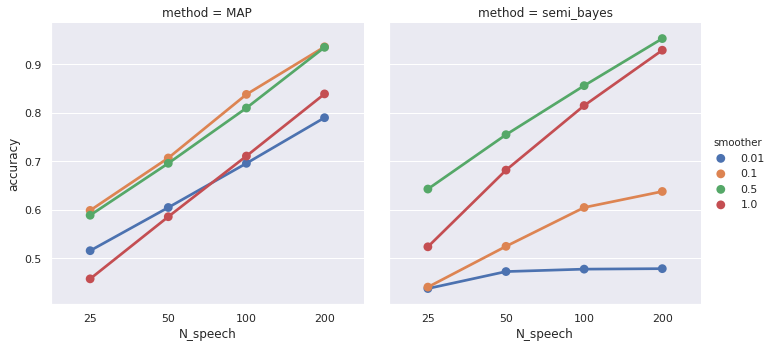

In [261]:
sns.set_style('darkgrid')
sns.catplot(kind='point', y = 'accuracy', x = 'N_speech', hue='smoother', col='method', style='method', ci=None, data = df2);

# Some other questions and connections

- *Why* do we expect a legislator's speech to be distinctive?
    - Agenda? Style? Framing? Formal role?
    - The answer might motivate more focused modeling choices.
- Other methods for assessing distinctiveness: one-class kernel SVMs (Schölkopf et al, 2001)
- Other comparisons of word distributions:
    - Symmetric KL and Jensen-Shannon divergence
    - Kernel-based metrics that can theoretically extend beyond bag-of-words analysis (Gretton et al., 2008)

# References

- Gretton, Arthur, Kenji Fukumizu, Choon H. Teo, Le Song, Bernhard Schölkopf, and Alex J. Smola. "A kernel statistical test of independence." In Advances in neural information processing systems, pp. 585-592. 2008.
- Juola, Patrick. "Authorship attribution." Foundations and Trends® in Information Retrieval 1, no. 3 (2008): 233-334.
- Stamatatos, Efstathios. "A survey of modern authorship attribution methods." Journal of the American Society for information Science and Technology 60, no. 3 (2009): 538-556.
- Schölkopf, Bernhard, John C. Platt, John Shawe-Taylor, Alex J. Smola, and Robert C. Williamson. "Estimating the support of a high-dimensional distribution." Neural computation 13, no. 7 (2001): 1443-1471.